In [1]:
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload

import bemcs

%config InlineBackend.figure_format = "retina"

# define els_obs as an object containing x_normals and y_normals with same as size as n_pts
class els_normals:
    def __init__(self, els, n):
        n_els = len(els.x1)
        self.x = np.zeros(n_els * n)
        self.y = np.zeros(n_els * n)
        self.x_shears = np.zeros(n_els * n)
        self.y_shears = np.zeros(n_els * n)
        self.x_normals = np.zeros(n_els * n)
        self.y_normals = np.zeros(n_els * n)
        self.lengths = np.zeros(n_els * n)

        for i in range(n_els):
            xvec = np.linspace(els.x1[i], els.x2[i], n + 1)
            yvec = np.linspace(els.y1[i], els.y2[i], n + 1)
            self.x[i * n : (i + 1) * n] = 0.5 * (xvec[1:] + xvec[0:-1])
            self.y[i * n : (i + 1) * n] = 0.5 * (yvec[1:] + yvec[0:-1])
            self.x_shears[i * n : (i + 1) * n] = els.x_shears[i]
            self.y_shears[i * n : (i + 1) * n] = els.y_shears[i]
            self.x_normals[i * n : (i + 1) * n] = els.x_normals[i]
            self.y_normals[i * n : (i + 1) * n] = els.y_normals[i]
            self.lengths[i * n : (i + 1) * n] = els.lengths[i] / n


def extract_quadratic_components(quadratic_coefs, n_els):
    # extract (s,n) components and store them in 2 separate vectors
    quadratic_coefs_s = np.zeros((3 * n_els, 1))
    quadratic_coefs_n = np.zeros((3 * n_els, 1))
    for i in range(n_els):
        quadratic_coefs_s[3 * i : 3 * (i + 1)] = quadratic_coefs[6 * i : 6 * i + 3]
        quadratic_coefs_n[3 * i : 3 * (i + 1)] = quadratic_coefs[
            6 * i + 3 : 6 * (i + 1)
        ]
    return quadratic_coefs_s, quadratic_coefs_n


class els_labels:
    def __init__(self, els, H, L):
        xmid = np.copy(els.x_centers)
        ymid = np.copy(els.y_centers)
        self.top = ymid == H  # top
        self.right = xmid == L  # right
        self.bot = ymid == -H  # top
        self.left = xmid == -L  # left

# Construct a fault inside a 4 meter x 4 meter sized box domain

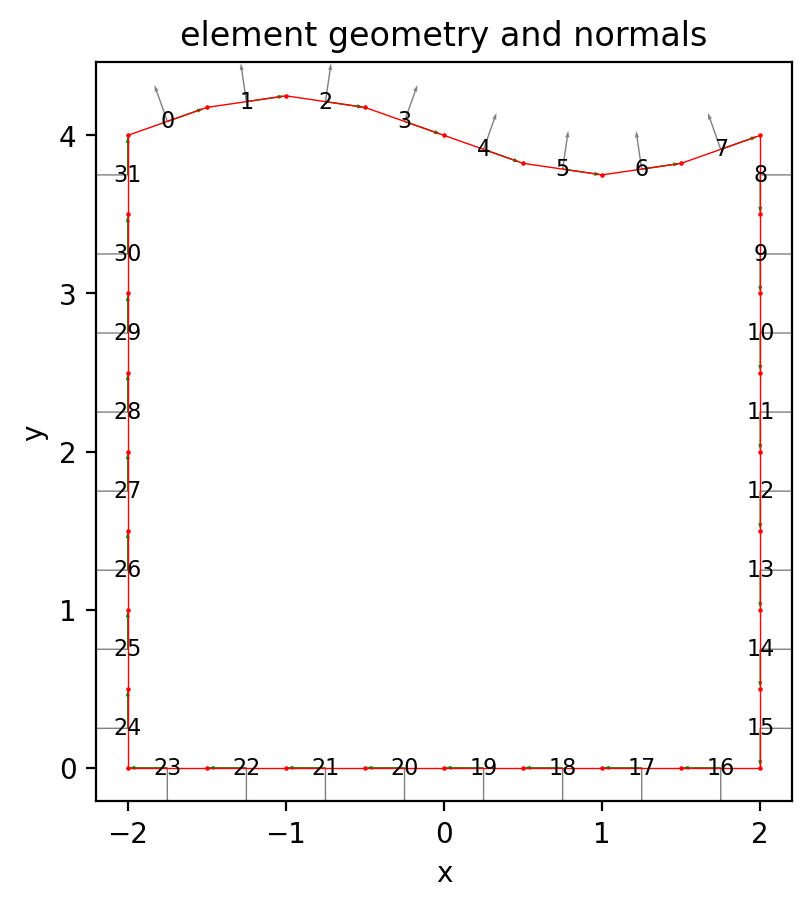

In [2]:
# Create a box mesh with a sinusoidal fault in the middle
L = 2.0
H = L * 1.0
ngrid = 4
corners = np.array([[-L, H], [L, H], [L, -H], [-L, -H], [-L, H]])

# Create arrays of the x and y coordinates of the corners
x, z = [], []
for i in range(4):
    lsegment = np.sqrt(
        (corners[i, 0] - corners[(i + 1), 0]) ** 2
        + (corners[i, 1] - corners[(i + 1), 1]) ** 2
    )
    xi = np.linspace(
        corners[i][0],
        corners[(i + 1) % 4][0],
        num=round(lsegment * ngrid / H),
        endpoint=False,
    )
    zi = np.linspace(
        corners[i][1],
        corners[(i + 1) % 4][1],
        num=round(lsegment * ngrid / H),
        endpoint=False,
    )
    x.append(xi)
    z.append(zi)
x.append(corners[0, 0])
z.append(corners[0, 1])
x = np.hstack(x)
z = np.hstack(z)

x1_box = x[0:-1]
x2_box = x[1:]
y1_box = z[0:-1]
y2_box = z[1:]

els = bemcs.initialize_els()
els.x1 = x1_box
els.y1 = y1_box - np.min(z)
els.x2 = x2_box
els.y2 = y2_box - np.min(z)

# Add a wavy top to the box
x_scale = -0.5
y_scale = 0.25
y_offset = 4.0
els.y1[0:8] = y_offset + y_scale * np.sin(x_scale * np.pi * els.x1[0:8])
els.y2[0:8] = y_offset + y_scale * np.sin(x_scale * np.pi * els.x2[0:8])


bemcs.standardize_els_geometry(els, reorder=False)
n_els = len(els.x1)
bemcs.plot_els_geometry(els)

# Hacky side labeling
labels = els_labels(els, H - np.min(z), L)
labels.bot[16:24] = True
labels.top[0:8] = True


# Elastic parameters
material_mu = 3e10
material_lambda = 3e10
nu = 0.25
rho = 2700
g = 9.81

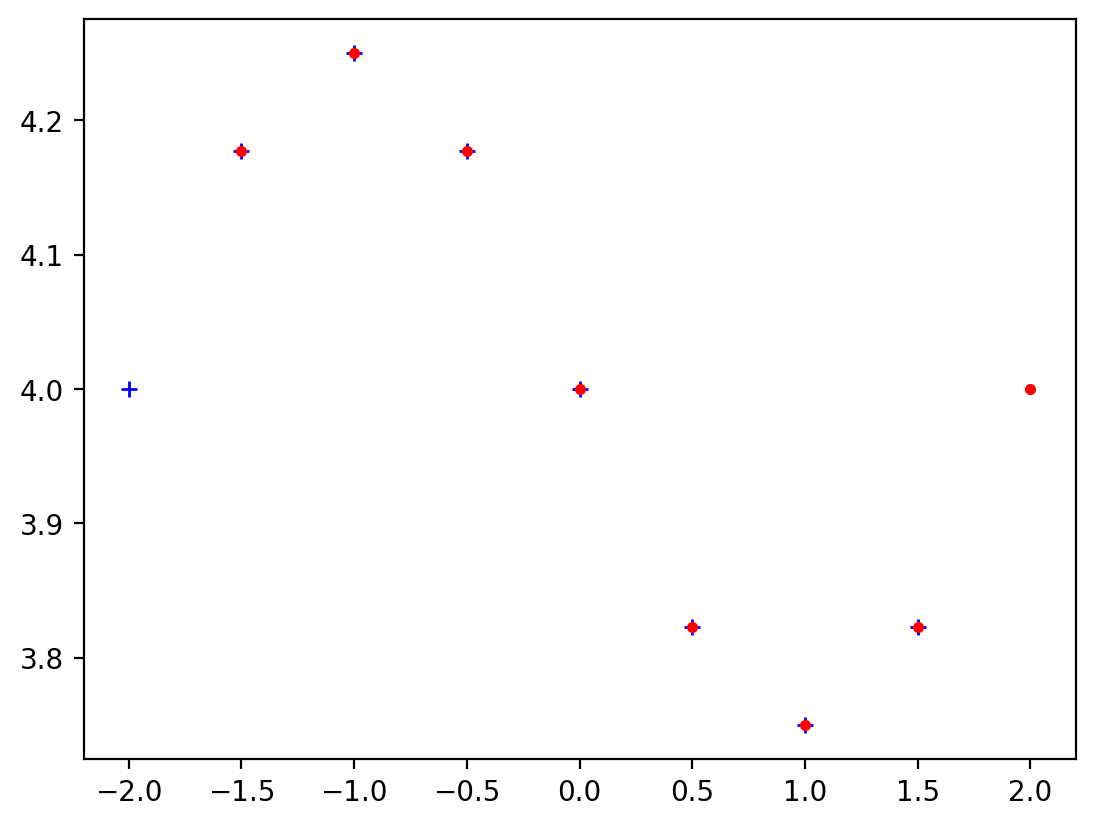

In [3]:
x_scale = -0.5
y_scale = 0.25
y_offset = 4.0
plt.plot(els.x1[0:8], y_offset + y_scale * np.sin(x_scale * np.pi * els.x1[0:8]), "b+")
plt.plot(els.x2[0:8], y_offset + y_scale * np.sin(x_scale * np.pi * els.x2[0:8]), "r.")

# Calculate the Pape and Banerjee (1987) gravity particular solution

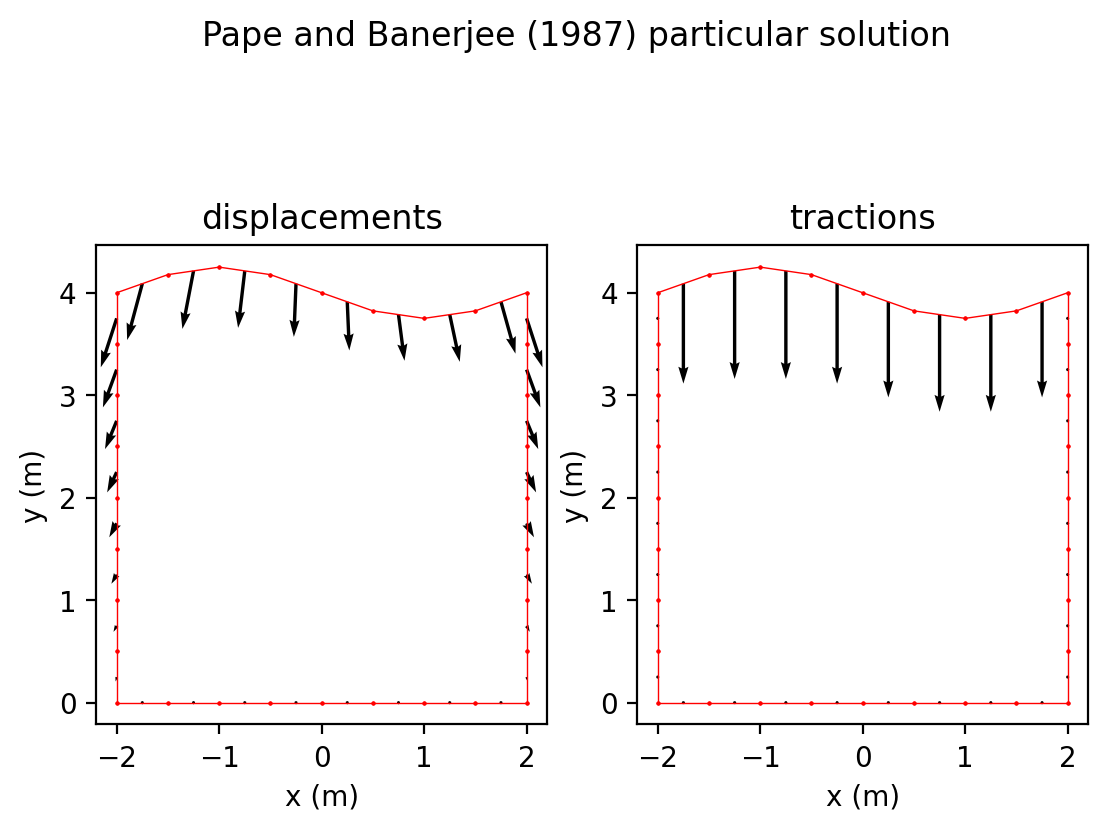

64


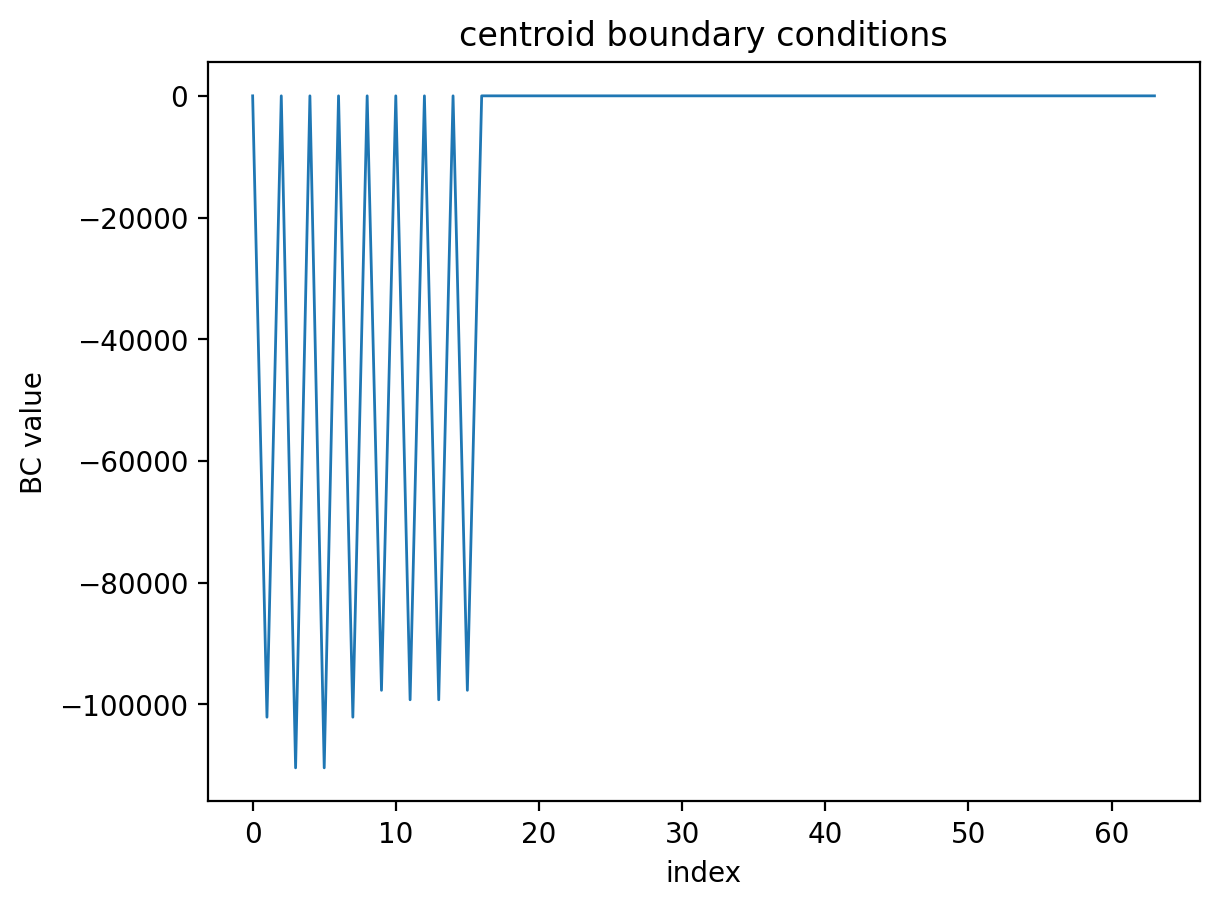

In [4]:
def get_gravity_particular_solution(x, y, g, rho, material_lambda, material_mu):
    """
    Compute the particular solution for the gravity effect on a material.

    This function calculates the displacement fields (ux, uy) and the stress components (sxx, syy, sxy)
    under the influence of gravity for a given material based on the equations provided by Pape and Banerjee (1987).

    Parameters:
    x (ndarray): Array of x-coordinates.
    y (ndarray): Array of y-coordinates.
    g (float): Gravitational acceleration.
    rho (float): Density of the material.
    material_lambda (float): First Lamé parameter of the material.
    material_mu (float): Second Lamé parameter (shear modulus) of the material.

    Returns:
    tuple: Tuple containing:
        ux (ndarray): Displacement in the x-direction.
        uy (ndarray): Displacement in the y-direction.
        sxx (ndarray): xx stress component (zero in this case).
        syy (ndarray): yy stress component.
        sxy (ndarray): xy stress component (zero in this case).
    """
    ux = (
        -material_lambda
        * rho
        * g
        / (4 * material_mu * (material_lambda + material_mu))
        * x
        * y
    )  # Pape and Banerjee (1987) equation (6a)
    uy = (
        (rho * g)
        / (8 * material_mu * (material_lambda + material_mu))
        * (material_lambda * x**2 + (material_lambda + 2 * material_mu) * y**2)
    )  # Pape and Banerjee (1987) equation (6b)
    sxx = np.zeros_like(x)  # Pape and Banerjee (1987) equation (6c)
    syy = rho * g * y  # Pape and Banerjee (1987) equation (6d)
    sxy = np.zeros_like(x)  # Pape and Banerjee (1987) equation (6e)
    return ux, uy, sxx, syy, sxy


ux, uy, sxx, syy, sxy = get_gravity_particular_solution(
    els.x_centers, els.y_centers, g, rho, material_lambda, material_mu
)

# Calculate tractions
tx = np.zeros_like(ux)
ty = np.zeros_like(ux)

for i in range(len(els)):
    stress_tensor = np.zeros((2, 2))
    stress_tensor[0, 0] = sxx[i]
    stress_tensor[1, 1] = syy[i]
    stress_tensor[0, 1] = sxy[i]
    stress_tensor[1, 0] = sxy[i]
    normal_vector = np.array([els.x_normals[i], els.y_normals[i]])
    traction_vector = stress_tensor @ normal_vector
    tx[i] = traction_vector[0]
    ty[i] = traction_vector[1]


plt.figure()
plt.subplot(1, 2, 1)
plt.title("displacements")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
for i in range(len(els.x1)):
    plt.plot(
        [els.x1[i], els.x2[i]],
        [els.y1[i], els.y2[i]],
        "-",
        color="r",
        linewidth=0.5,
    )
    plt.plot(
        [els.x1[i], els.x2[i]],
        [els.y1[i], els.y2[i]],
        "r.",
        markersize=1,
        linewidth=0.5,
    )
plt.quiver(els.x_centers, els.y_centers, -ux, -uy)
plt.gca().set_aspect("equal")

plt.subplot(1, 2, 2)
plt.title("tractions")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
for i in range(len(els.x1)):
    plt.plot(
        [els.x1[i], els.x2[i]],
        [els.y1[i], els.y2[i]],
        "-",
        color="r",
        linewidth=0.5,
    )
    plt.plot(
        [els.x1[i], els.x2[i]],
        [els.y1[i], els.y2[i]],
        "r.",
        markersize=1,
        linewidth=0.5,
    )
plt.quiver(els.x_centers, els.y_centers, -tx, -ty)
plt.gca().set_aspect("equal")
plt.suptitle("Pape and Banerjee (1987) particular solution")
plt.show()

# Apply particular solution boundary conditions at central nodes
N_c = 2 * n_els
print(N_c)
BC_c = np.zeros((N_c, 1))  # these are the only non-zero entries
BC_c[0:16:2, 0] = -tx[0:8]
BC_c[1:16:2, 0] = -ty[0:8]

plt.figure()
plt.title("centroid boundary conditions")
plt.xlabel("index")
plt.ylabel("BC value")
plt.plot(BC_c, linewidth=1.0)
plt.show()

# `bemcs` labels nodes and calculates kernels

Number of open nodes = 0
: []
Number of 2-overlap nodes = 32
: [array([ 72, -71]), array([ 75, -74]), array([ 78, -77]), array([ 81, -80]), array([ 84, -83]), array([ 87, -86]), array([ 90, -89]), array([ 93, -92]), array([  0, -95]), array([ 69, -68]), array([ 3, -2]), array([ 66, -65]), array([ 6, -5]), array([ 63, -62]), array([ 9, -8]), array([ 60, -59]), array([ 12, -11]), array([ 57, -56]), array([ 15, -14]), array([ 54, -53]), array([ 18, -17]), array([ 51, -50]), array([ 21, -20]), array([ 48, -47]), array([ 45, -44]), array([ 42, -41]), array([ 39, -38]), array([ 36, -35]), array([ 33, -32]), array([ 30, -29]), array([ 27, -26]), array([ 24, -23])]
Number of triple junctions = 0
: []
HERE
idx=array([ True,  True,  True,  True,  True,  True,  True,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False])


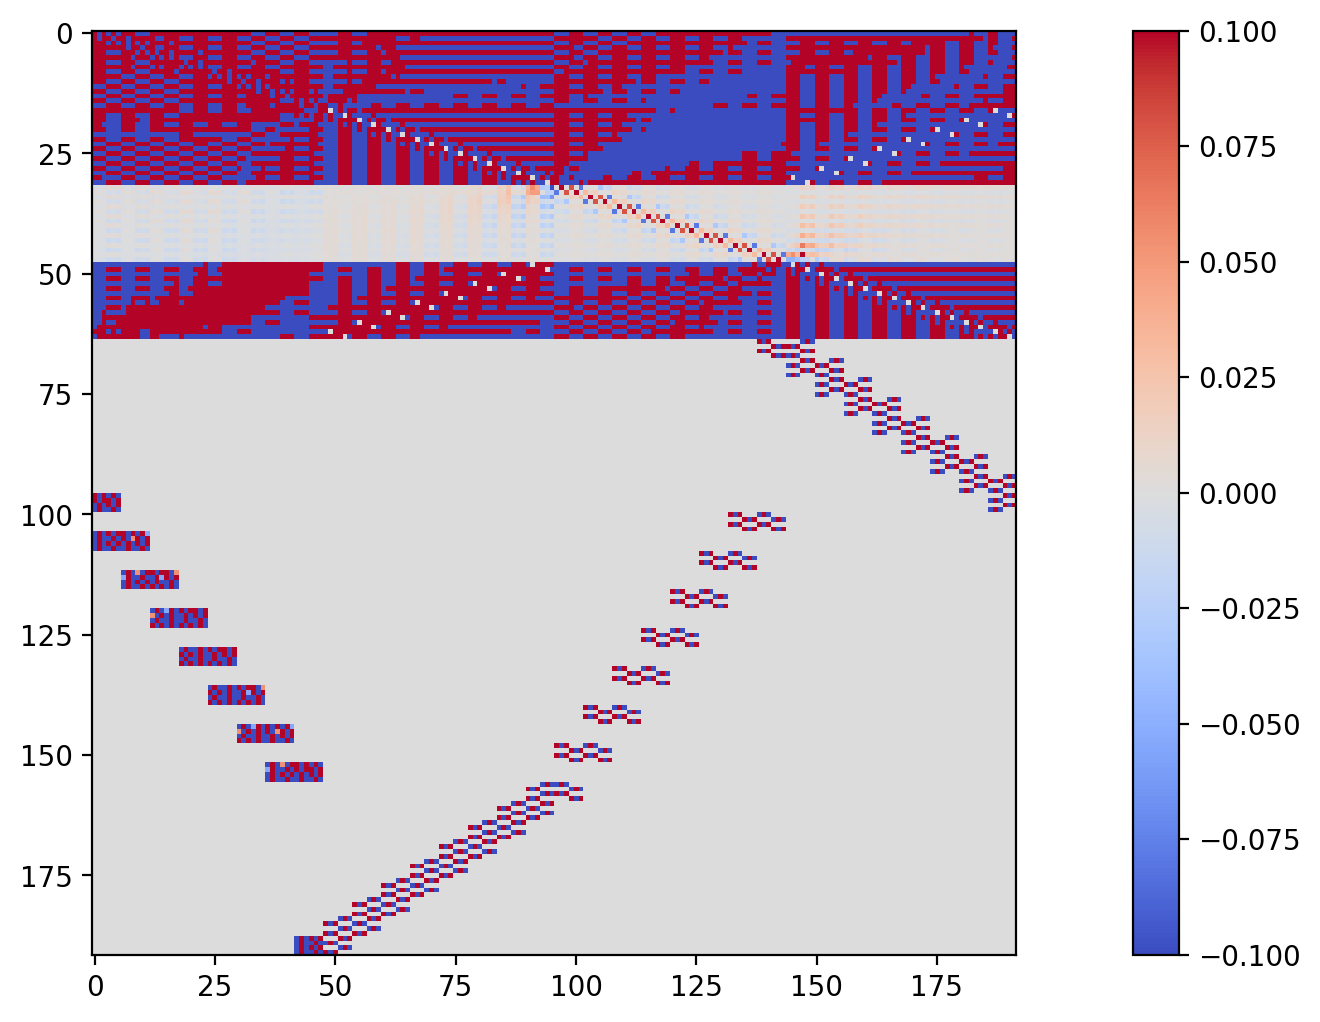

In [5]:
index_open, index_overlap, index_triple = bemcs.label_nodes(els)
N_c = 2 * n_els  # central node equations
N_o = 2 * len(index_open)  # open node equations
N_i = 4 * len(index_overlap)  # overlapping node equations
N_t = 6 * len(index_triple)  # triple junction equations

Nequations = N_c + N_o + N_i + N_t
Nunknowns = 6 * n_els

# We will stack this with
# equations for the element centers
# equations at open nodes (RHS = 0)
# equations at overlapping nodes (RHS = 0)
# equations at triple junctions (RHS = 0)
BC_c = np.zeros((N_c, 1))  # these are the only non-zero entries
BC_o = np.zeros((N_o, 1))
BC_i = np.zeros((N_i, 1))
BC_t = np.zeros((N_t, 1))

# Apply BCs at central nodes
# TODO: Modify here
# BC_c[0::2, 0] = traction_vector_x
# BC_c[1::2, 0] = traction_vector_y
BC_c[0:16:2, 0] = -tx[0:8]
BC_c[1:16:2, 0] = -ty[0:8]
# BC_c[0:16:2, 0] = 0.0
# BC_c[1:16:2, 0] = 1.0

# stack all the BCs into 1 big vector
BCvector = np.vstack((BC_c, BC_o, BC_i, BC_t))

# Design matrices (in x, y coordinates) for slip and slip gradients at each 3qn
# matrix_slip, matrix_slip_gradient = bemcs.get_matrices_slip_slip_gradient(
#     els, reference="local"
# )
matrix_slip, matrix_slip_gradient = bemcs.get_matrices_slip_slip_gradient(
    els, reference="local"
)

# Patch center locations
obs_xy = np.vstack((els.x_centers, els.y_centers)).T
dr = -1e-6
x_obs = (obs_xy[:, 0] + els.x_normals * dr).reshape(-1, 1)
y_obs = (obs_xy[:, 1] + els.y_normals * dr).reshape(-1, 1)

# Compute shear and tensile stress kernels evaluated ONLY at the center of each element
kernels_s = bemcs.get_displacement_stress_kernel(
    x_obs, y_obs, els, material_mu, nu, "shear"
)
kernels_n = bemcs.get_displacement_stress_kernel(
    x_obs, y_obs, els, material_mu, nu, "normal"
)

# Convert to traction kernels [Nobs x Ncoefficients]
traction_kernels_s = bemcs.get_traction_kernels(els, kernels_s, flag="global")
traction_kernels_n = bemcs.get_traction_kernels(els, kernels_n, flag="global")

# Linear Operators for the appropriate boundary conditions
matrix_system_c = np.zeros((N_c, Nunknowns))
matrix_system_o = np.zeros((N_o, Nunknowns))
matrix_system_i = np.zeros((N_i, Nunknowns))
matrix_system_t = np.zeros((N_t, Nunknowns))

# Linear operator for central node BCs
kerneleval_x = np.zeros((n_els, Nunknowns))
kerneleval_y = np.zeros((n_els, Nunknowns))

for i in range(4):
    if i == 0:  # TOP: Displacement
        print("HERE")
        idx = labels.top.flatten()
        print(f"{idx=}")
        kernel_for_x_s = traction_kernels_s[0]
        kernel_for_x_n = traction_kernels_n[0]
        kernel_for_y_s = traction_kernels_s[1]
        kernel_for_y_n = traction_kernels_n[1]

    elif i == 1:  # RIGHT: Traction
        idx = labels.right.flatten()
        kernel_for_x_s = traction_kernels_s[0]
        kernel_for_x_n = traction_kernels_n[0]
        kernel_for_y_s = traction_kernels_s[1]
        kernel_for_y_n = traction_kernels_n[1]

    elif i == 2:  # BOTTOM: Displacement
        idx = labels.bot.flatten()
        kernel_for_x_s = kernels_s[3]
        kernel_for_x_n = kernels_n[3]
        kernel_for_y_s = kernels_s[4]
        kernel_for_y_n = kernels_n[4]

    elif i == 3:  # LEFT: Traction
        idx = labels.left.flatten()
        kernel_for_x_s = traction_kernels_s[0]
        kernel_for_x_n = traction_kernels_n[0]
        kernel_for_y_s = traction_kernels_s[1]
        kernel_for_y_n = traction_kernels_n[1]

    # x-kernels
    kerneleval_x[idx, 0::6] = kernel_for_x_s[idx, 0::3]
    kerneleval_x[idx, 1::6] = kernel_for_x_s[idx, 1::3]
    kerneleval_x[idx, 2::6] = kernel_for_x_s[idx, 2::3]
    kerneleval_x[idx, 3::6] = kernel_for_x_n[idx, 0::3]
    kerneleval_x[idx, 4::6] = kernel_for_x_n[idx, 1::3]
    kerneleval_x[idx, 5::6] = kernel_for_x_n[idx, 2::3]

    # y-kernels
    kerneleval_y[idx, 0::6] = kernel_for_y_s[idx, 0::3]
    kerneleval_y[idx, 1::6] = kernel_for_y_s[idx, 1::3]
    kerneleval_y[idx, 2::6] = kernel_for_y_s[idx, 2::3]
    kerneleval_y[idx, 3::6] = kernel_for_y_n[idx, 0::3]
    kerneleval_y[idx, 4::6] = kernel_for_y_n[idx, 1::3]
    kerneleval_y[idx, 5::6] = kernel_for_y_n[idx, 2::3]


# Populate central nodes of matrix_system
matrix_system_c[0::2, :] = kerneleval_x
matrix_system_c[1::2, :] = kerneleval_y

# Create smoothness matrices
matrix_system_o, matrix_system_i, matrix_system_t = bemcs.construct_smoothoperator(
    els, index_open, index_overlap, index_triple
)

# Ctack the matrices and create the full linear operator
matrix_system = np.vstack(
    (matrix_system_c, matrix_system_o, matrix_system_i, matrix_system_t)
)

# plot design matrix
plt.figure(figsize=(15, 6))
plt.imshow(matrix_system, cmap="coolwarm")
plt.colorbar()
plt.clim(-0.1, 0.1)
plt.show()

In [6]:
print(matrix_system.shape)
print(np.linalg.cond(matrix_system))
print(np.linalg.matrix_rank(matrix_system))

(192, 192)
2377080298459.057
192


In [7]:
# Compute quadratic node coefficients (in local (s,n) coordinates)
quadratic_coefs = np.linalg.inv(matrix_system) @ BCvector
print("Linear Operator Condition Number:", np.linalg.cond(matrix_system))

# Extract (s,n) components and store them in 2 separate vectors
quadratic_coefs_s = np.zeros((3 * n_els, 1))
quadratic_coefs_n = np.zeros((3 * n_els, 1))
for i in range(n_els):
    quadratic_coefs_s[3 * i : 3 * (i + 1)] = quadratic_coefs[6 * i : 6 * i + 3]
    quadratic_coefs_n[3 * i : 3 * (i + 1)] = quadratic_coefs[6 * i + 3 : 6 * (i + 1)]

Linear Operator Condition Number: 2377080298459.057


# Calculate internal elastic deformation at observation points

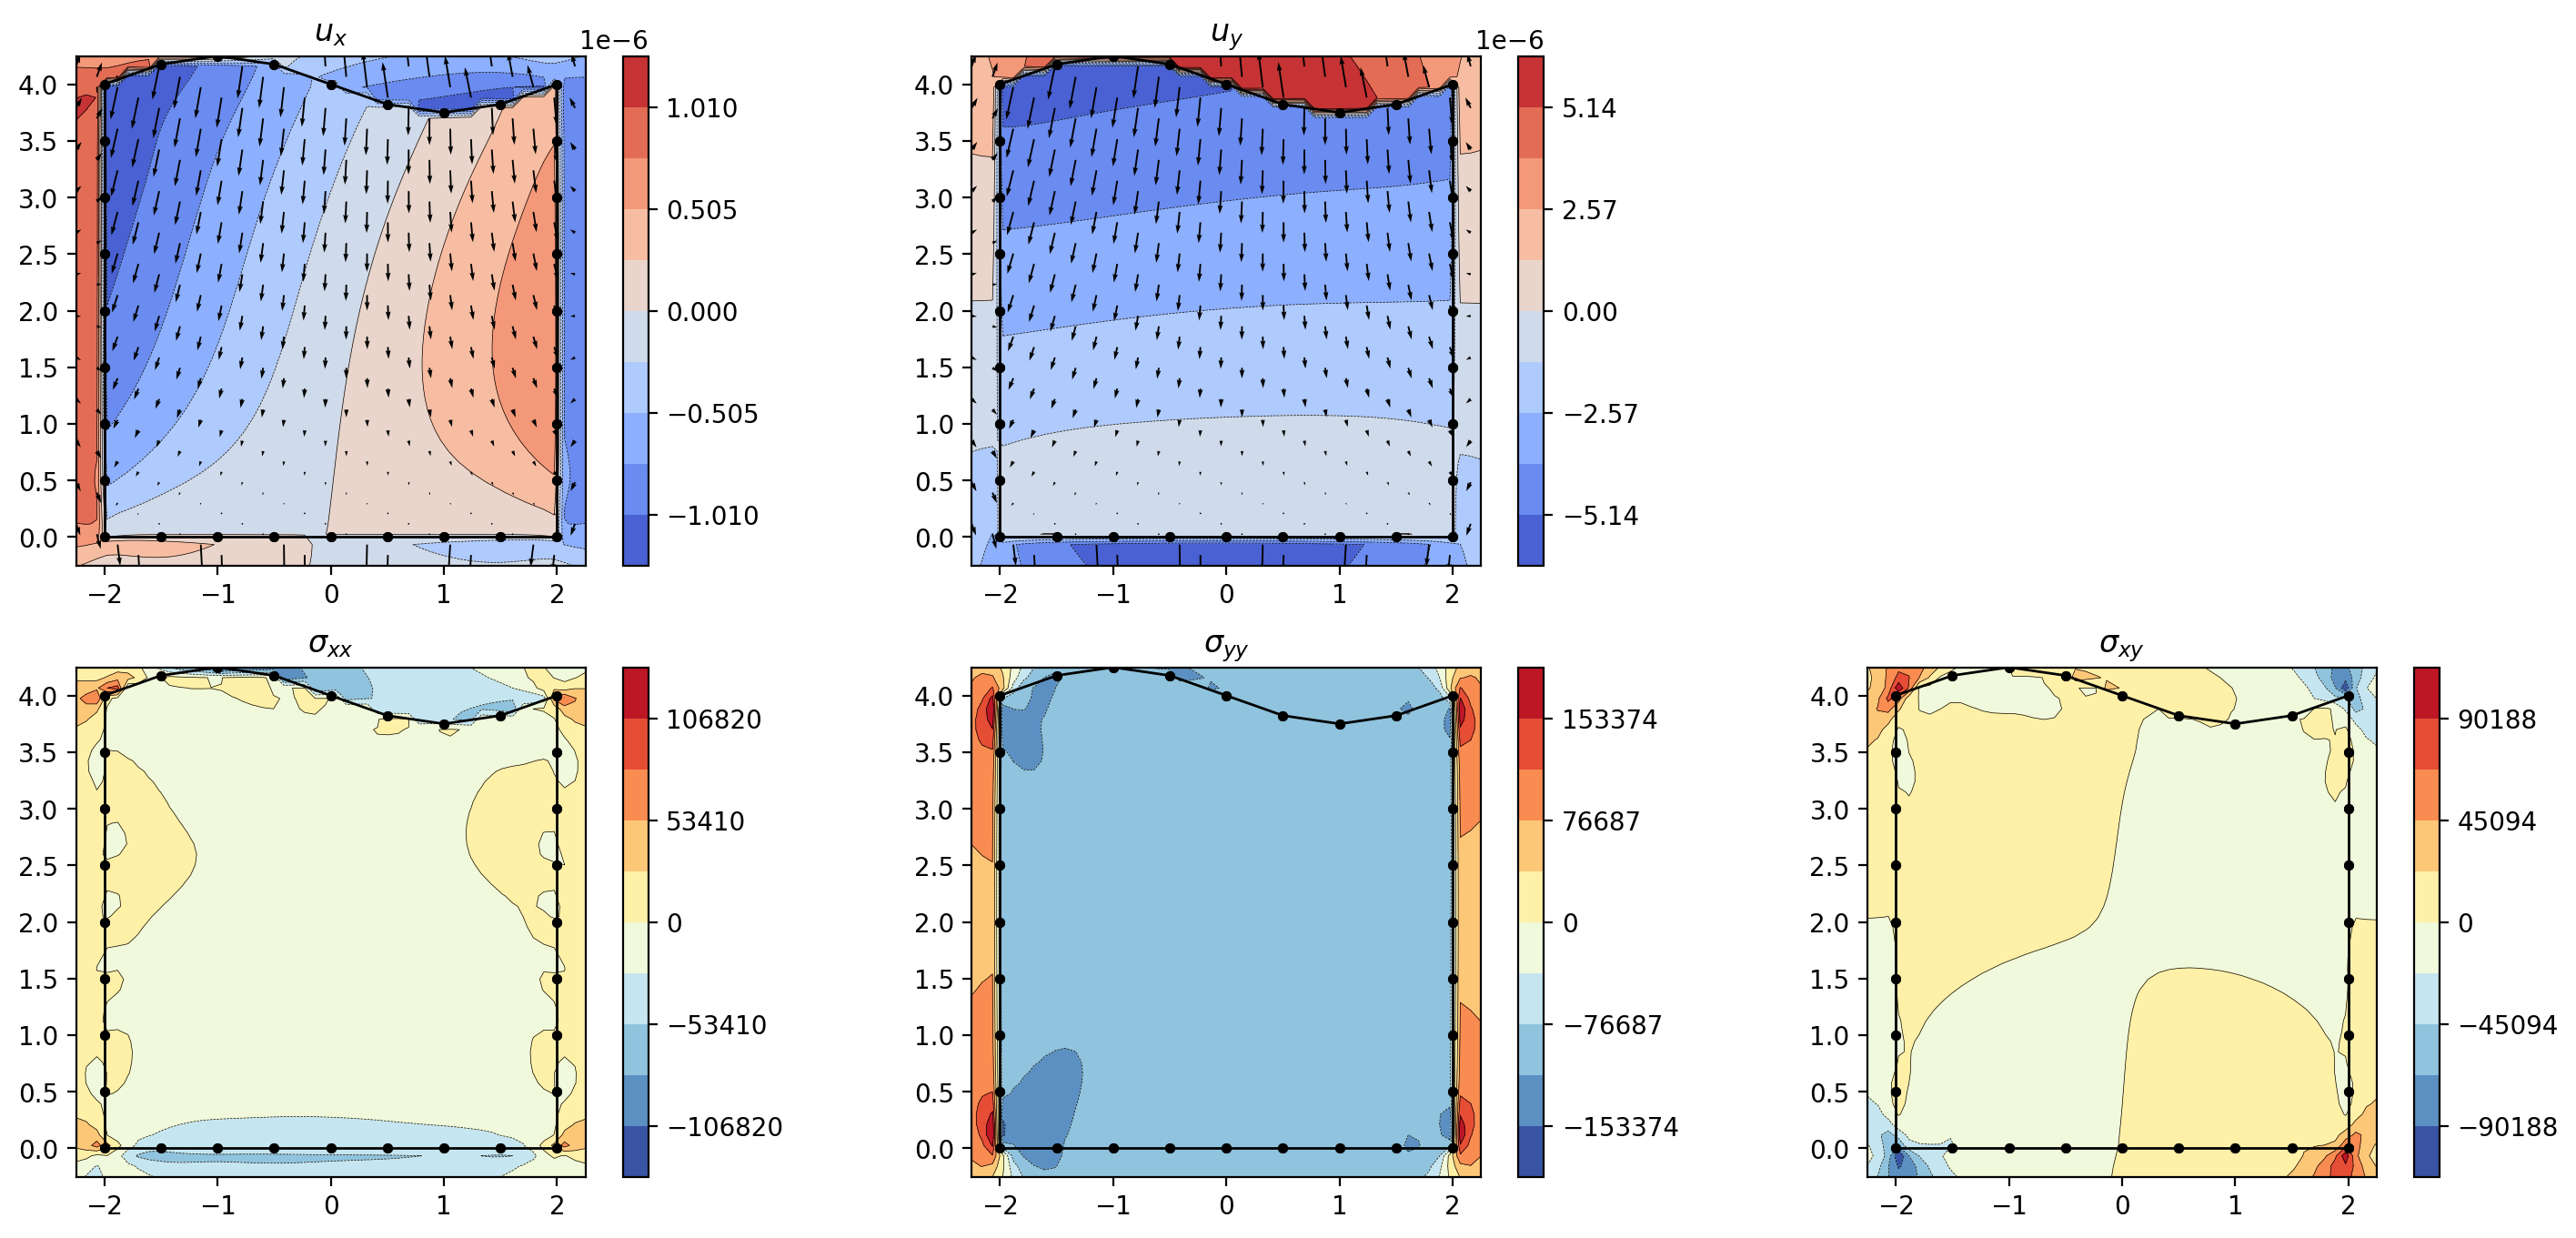

In [8]:
# Observation points
n_obs = 50
# x_plot = np.linspace(-1.999, 1.999, n_obs)
# y_plot = np.linspace(0.001, 3.999, n_obs)
x_plot = np.linspace(-2.25, 2.25, n_obs)
y_plot = np.linspace(-0.25, 4.25, n_obs)


x_plot, y_plot = np.meshgrid(x_plot, y_plot)
x_plot = x_plot.flatten()
y_plot = y_plot.flatten()

# Compute shear and tensile stress kernels
kernels_s = bemcs.get_displacement_stress_kernel(
    x_plot, y_plot, els, material_mu, nu, "shear"
)
kernels_n = bemcs.get_displacement_stress_kernel(
    x_plot, y_plot, els, material_mu, nu, "normal"
)

# Compute displacement and stresses (we will plot it later)
ux, uy, sxx, syy, sxy = bemcs.coeffs_to_disp_stress(
    kernels_s, kernels_n, quadratic_coefs_s, quadratic_coefs_n
)

bemcs.plot_displacements_stresses_els(
    els, n_obs, ux, uy, sxx, syy, sxy, x_plot, y_plot, n_skip_plot=8
)

# Calculate total stress by adding lithostatic component to elastic component
The particular solution approach (Pape and Banerjee, 1987) used here provides a set of boundary conditions consistent with loading of an elastic body by a body force acting in just one direction.  In this case the vertical velocities exhibit a physically reasonable near linear displacement gradient consistent with approoximately constand $\epsilon_{yy}$ strain in the body.  This also means that the vertical stress, $\sigma_{yy}$ is approximately constant in the body.  To make the model consistent with the concept of elastic deformation and "lithostatic" stress a lithostsatic stress can be added to the elastic stress tensor to get the total stress: $\sigma_{xx}^\mathrm{total} = \sigma_{xx}^\mathrm{elastic} + \rho g y$ and $\sigma_{yy}^\mathrm{total} = \sigma_{yy}^\mathrm{elastic} + \rho g y$.

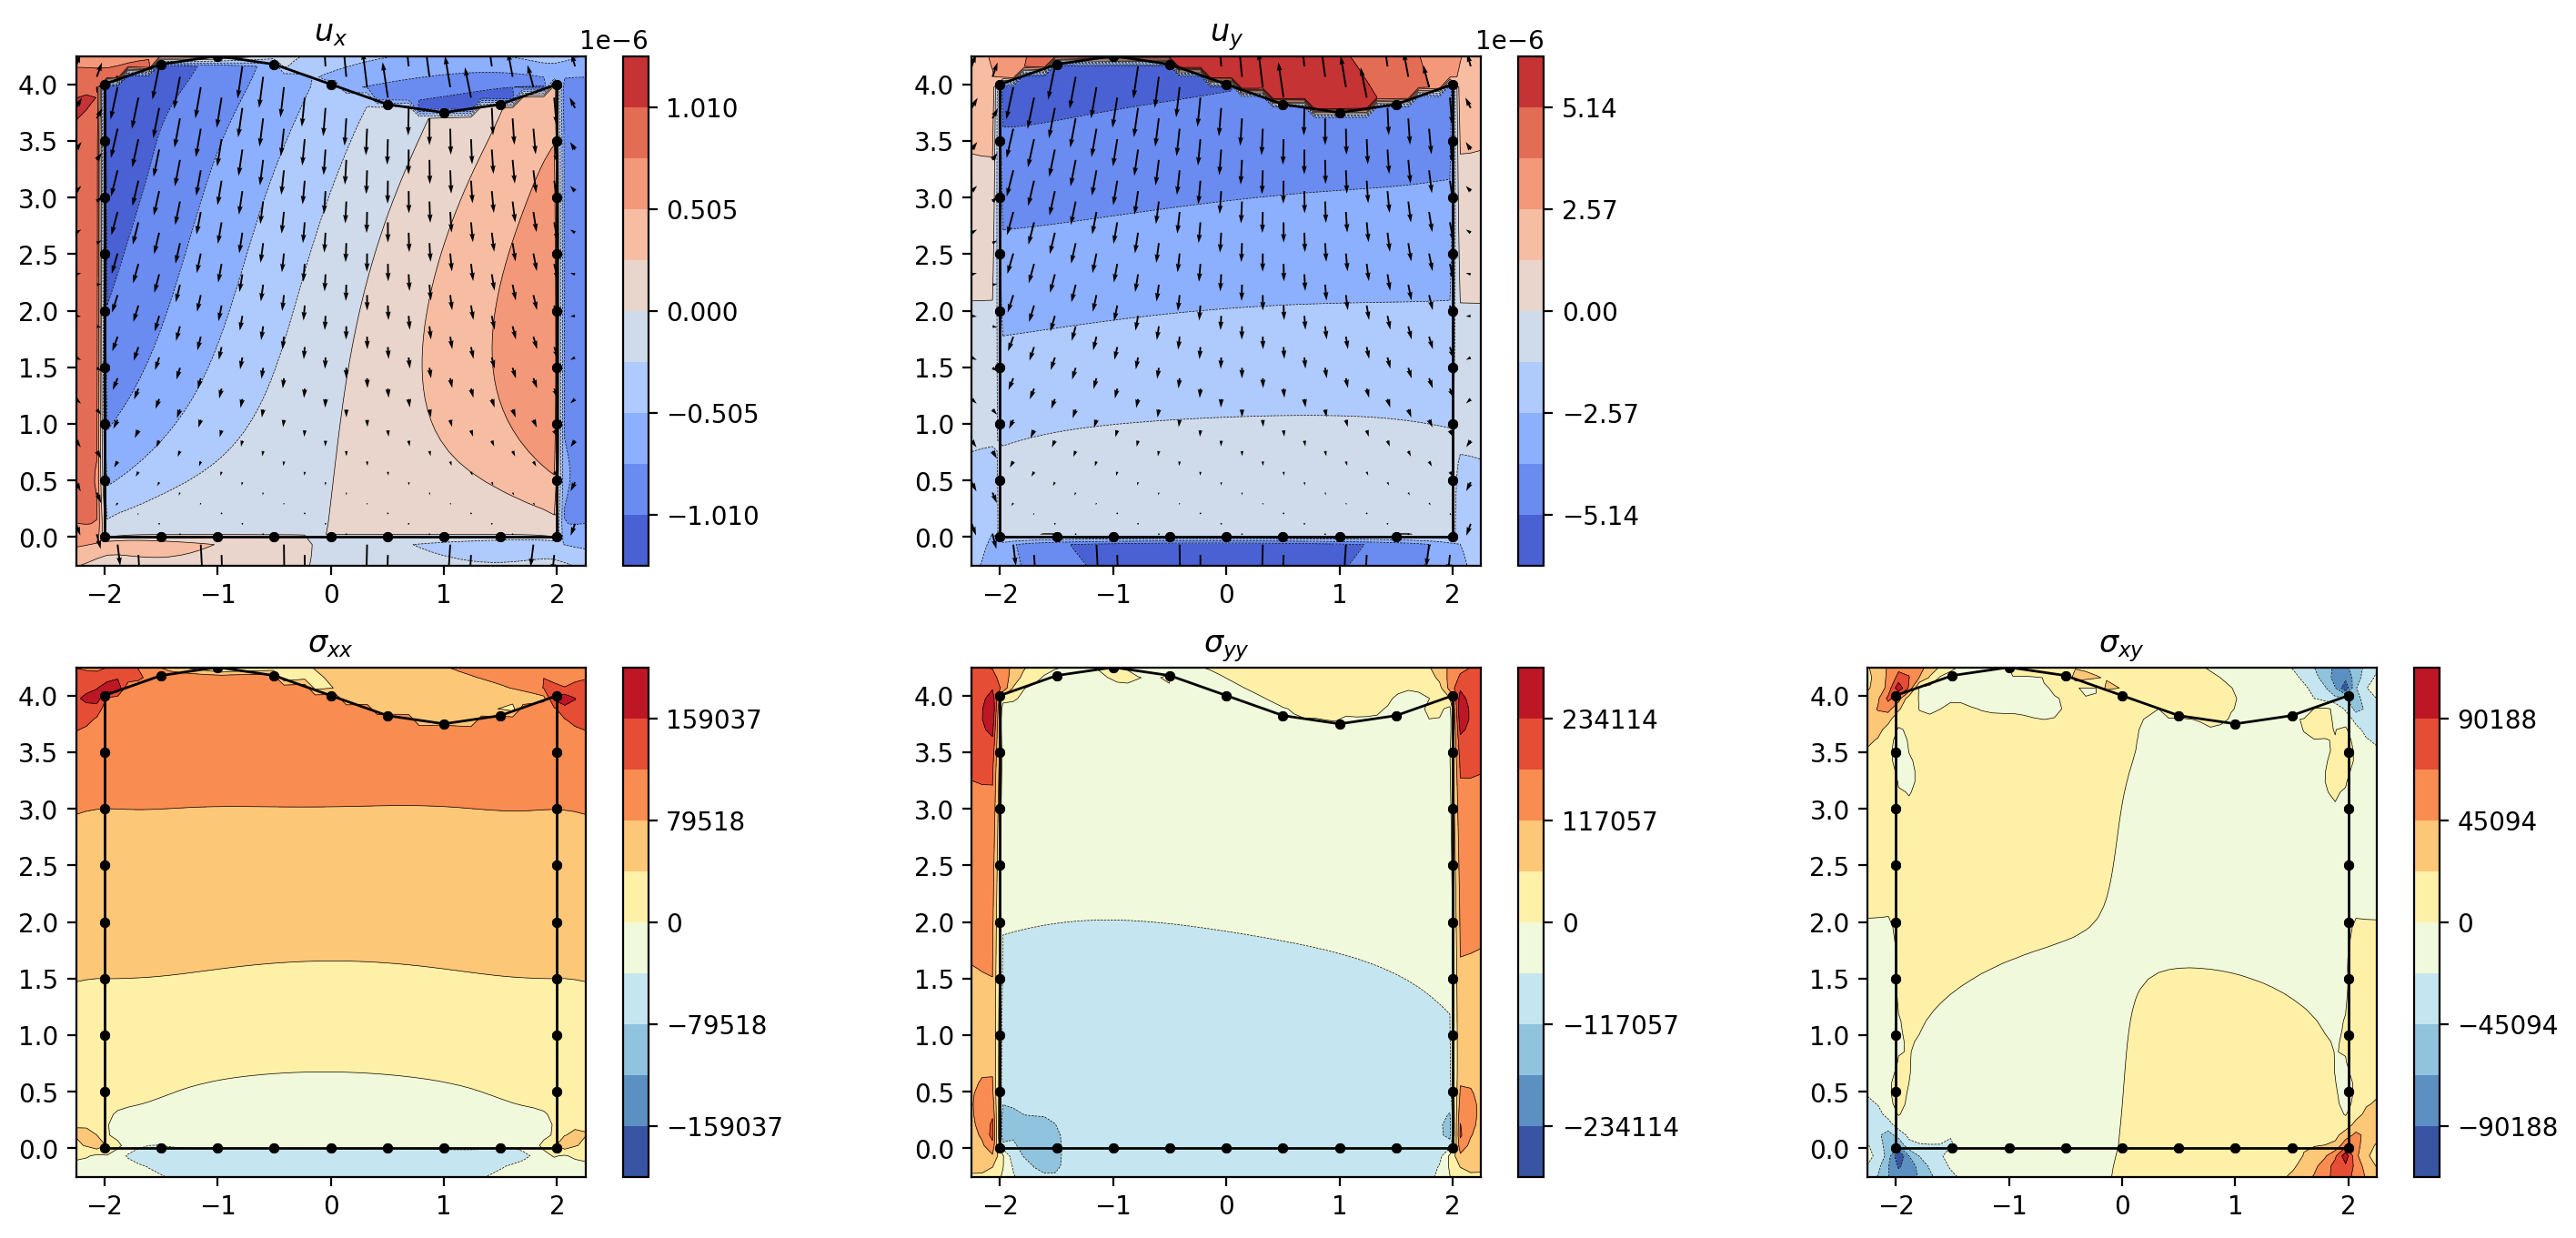

In [9]:
# Add "lithostatic" stress to elastic stress
sxx_total = sxx.flatten() + rho * g * y_plot.flatten()
syy_total = syy.flatten() + rho * g * y_plot.flatten()
sxy_total = sxy.flatten()

bemcs.plot_displacements_stresses_els(
    els,
    n_obs,
    ux,
    uy,
    sxx_total,
    syy_total,
    sxy_total,
    x_plot,
    y_plot,
    n_skip_plot=8,
)